<a href="https://colab.research.google.com/github/maxsolomonhenry/mlp/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn import metrics

Two Layer Multilayer Perceptron Class:

In [0]:
# Todo:
#       dropout w/ probability.
#       cost on train vs. validation set graph.


class TwoLayerMLP:
    def __init__(self, n_epochs=2, learning_rate=0.1, batch_size=32, n_inputs=3072, n_outputs=10,
                 hidden_layer_width=100, hidden_activation='relu', momentum = 0.99, lr_decay=True, verbose=False,
                 show_plots=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.hidden_layer_width = hidden_layer_width
        self.hidden_activation = hidden_activation
        self.momentum = momentum
        self.verbose = verbose
        self.show_plots = show_plots
        self.V = torch.tensor([])
        self.W = torch.tensor([])
        self.momentum_V = torch.tensor([])
        self.momentum_W = torch.tensor([])
        self.inputs = torch.tensor([])
        self.labels = torch.tensor([])
        self.X = torch.tensor([])
        self.Y = torch.tensor([])
        self.Y_hat = torch.tensor([])
        self.A1 = torch.tensor([])
        self.Z1 = torch.tensor([])
        self.Z2 = torch.tensor([])
        self.test_Y = torch.tensor([])
        self.test_Y_hat = torch.tensor([])
        self.cost = []
        self.accuracy = []
        self.prfs = []
        self.lr_decay_rate = 0

        if lr_decay:
          self.lr_decay_rate = self.learning_rate/self.n_epochs 


    @staticmethod
    def hyperbolic_tangent(Z):
        return Z.tanh()

    @staticmethod
    def hyperbolic_tangent_derivative(Z):
        return 1 - Z.tanh() ** 2

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + torch.exp(-Z))

    @staticmethod
    def relu(Z):
        return torch.clamp(Z, min=0)

    @staticmethod
    def relu_subgradient(Z):
        return torch.clamp(torch.sign(Z), min=0)

    @staticmethod
    def softmax(Z):
        # Transposing is to allow for row-wise operations (with built-in broadcasting)
        max_dim = 1
        if Z.ndim == 1:
            max_dim = 0
        Z0_transpose = Z.t() - Z.max(max_dim)[0]
        Y_hat_transpose = torch.exp(Z0_transpose)
        Y_hat_transpose /= Y_hat_transpose.sum(0)
        Y_hat = Y_hat_transpose.t()
        return Y_hat

    @staticmethod
    def cross_entropy_loss(y_hat, y):
        return -torch.dot(y, torch.log(y_hat + 1e-9))

    @staticmethod
    def cross_entropy_grad(y_hat, y):
        return -(y * 1 / y_hat) + (1 - y) * (1 / (1 - y_hat))

    @staticmethod
    def tensor_width(tensor):
        if len(list(tensor.shape)) == 2:
            return tensor.size(1)
        elif len(list(tensor.shape)) == 1:
            return 1
        else:
            raise ValueError('Tensor must be one or two dimensions.')

    def batch_cross_entropy_loss(self):
        cost = 0
        for i in range(self.Y.shape[0]):
            cost += self.cross_entropy_loss(self.Y_hat[i, :], self.Y[i, :])
        cost /= self.Y.shape[0]
        return cost

    def matrixify(self, y):
        y = y.long()
        n_instances = y.shape[0]
        Y = torch.zeros(n_instances, self.n_outputs)
        for i in range(n_instances):
            Y[i, y[i]] = 1
        return Y

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def softmax_grad(self, Z):
        # This code adapted from https://link.medium.com/OgOkKMjCz5
        soft_max_result = self.softmax(Z)
        reshaped = soft_max_result.view(-1, 1)
        return torch.diagflat(reshaped) - torch.ger(reshaped[:, 0], reshaped[:, 0])

    def activation(self, Z, output=False, derivative=False):
        if not output:
            function = self.hidden_activation
        else:
            function = 'softmax'

        if not derivative:
            if function == 'relu':
                return self.relu(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent(Z)
            elif function == 'sigmoid':
                return self.sigmoid(Z)
            elif function == 'softmax':
                return self.softmax(Z)
            else:
                raise ValueError("Invalid activation function.")
        else:
            if function == 'relu':
                return self.relu_subgradient(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent_derivative(Z)
            elif function == 'sigmoid':
                return self.sigmoid_derivative(Z)
            elif function == 'softmax':
                return self.softmax_grad(Z)
            else:
                raise ValueError("Invalid activation function.")

    def initialize_weights(self):
        num_categories = self.n_outputs
        num_features = self.n_inputs
        self.W = torch.normal(0., 1., [num_features, self.hidden_layer_width])
        self.W = self.W.to(self.device)
        self.V = torch.normal(0., 1., [self.hidden_layer_width, num_categories])
        self.V = self.V.to(self.device)
        self.momentum_W = torch.zeros([num_features, self.hidden_layer_width])
        self.momentum_W = self.momentum_W.to(self.device)
        self.momentum_V = torch.zeros([self.hidden_layer_width, num_categories])
        self.momentum_V = self.momentum_V.to(self.device)

    def set_XY(self, data):
        images = data[0]
        labels = data[1]
        self.X = images.flatten(start_dim=1)
        self.X = self.X.to(self.device)
        self.Y = self.matrixify(labels)
        self.Y = self.Y.to(self.device)

    def predict_one_batch(self):
        # N = number of instances in mini batch
        # M = number of hidden units
        # C = number of output categories
        self.Z1 = torch.mm(self.X, self.W)  # (N x D) x (D x M) -> (N x M)
        self.A1 = self.activation(self.Z1)
        self.Z2 = torch.mm(self.A1, self.V)  # (N x M) x (M x C) -> (N x C)
        self.Y_hat = self.activation(self.Z2, output=True)

    def train_one_batch(self):
        self.predict_one_batch()

        delta_V = torch.zeros([self.V.shape[0], self.V.shape[1]])
        delta_V = delta_V.to(self.device)
        delta_W = torch.zeros([self.W.shape[0], self.W.shape[1]])
        delta_W = delta_W.to(self.device)

        n_instances = self.Y_hat.shape[0]
        for i in range(n_instances):
            """Accumulate gradients for W and V.
            Note that this is done in mini-batch form, based on the calculation:
              y_hat = g([h(XW)]V),
            where X is the design matrix. As a result, the dimensions of W and V 
            are transposed when compared to the notes in class.
            """
            loss_and_softmax_grad = self.Y_hat[i, :] - self.Y[i, :]  # (C) vector
            delta_V += torch.ger(self.A1[i, :], loss_and_softmax_grad)  # outer product makes (M x C) matrix
            row_calculation = torch.mv(self.V, loss_and_softmax_grad) * self.activation(self.Z1[i, :], derivative=True)  # (M) vector
            delta_W += torch.ger(self.X[i, :], row_calculation)  # outer product makes (D x M) matrix
        # Average gradients.
        delta_V /= self.batch_size
        delta_W /= self.batch_size
        # Add momentum.
        delta_V = (1 - self.momentum) * delta_V + self.momentum * self.momentum_V
        delta_W = (1 - self.momentum) * delta_W + self.momentum * self.momentum_W
        # Gradient descent.
        self.V -= self.learning_rate * delta_V
        self.W -= self.learning_rate * delta_W
        # Save gradient values for momentum.
        self.momentum_V = delta_V
        self.momentum_W = delta_W

    def train_one_epoch(self, train_loader):
        for i, data in enumerate(train_loader):
            self.set_XY(data)
            self.train_one_batch()
            self.cost.append(self.batch_cross_entropy_loss())

    def plot_cost(self):
        plt.plot(self.cost)
        plt.ylabel('Cost')
        plt.xlabel('Mini-batches')
        plt.show()
    
    def train(self, train_dataset):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.initialize_weights()
        self.cost = []
        for i in range(self.n_epochs):
            self.train_one_epoch(train_loader)
            self.learning_rate /= (1 + self.lr_decay_rate*i)
            if self.verbose: print("Finished training epoch %d." % (i+1))
        if self.show_plots:
            self.plot_cost()

    def initialize_test_Ys(self):
      self.test_Y = torch.tensor([])
      self.test_Y_hat = torch.tensor([])

    def accumulate_test_Ys(self):
      if self.test_Y.nelement() == 0:
        self.test_Y = self.Y.to(device='cpu')
        self.test_Y_hat = self.Y_hat.to(device='cpu')
      else:
        self.test_Y = torch.cat([self.test_Y, self.Y.to(device='cpu')])
        self.test_Y_hat = torch.cat([self.test_Y_hat, self.Y_hat.to(device='cpu')])

    def test(self, test_dataset, final_test=False):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        self.initialize_test_Ys()
        for i, data in enumerate(test_loader):
          self.set_XY(data)
          self.predict_one_batch()
          self.accumulate_test_Ys()
        if final_test:
          self.evaluate_final()

    def convert_to_01(self, soft_input):
        return self.matrixify(soft_input.max(dim=1)[1])

    def initialize_metrics(self):
      self.accuracy = []
      # self.prfs = []

    def evaluate_fold(self, i=0):
      test_Y_hat_01 = self.convert_to_01(self.test_Y_hat)
      self.accuracy.append(metrics.accuracy_score(self.test_Y, test_Y_hat_01))
      # self.prfs.append(metrics.precision_recall_fscore_support(self.Y, Y_hat_01, average='micro'))
      if self.verbose:
        print("Fold %d:\n\tacc. = %f" %(i+1, self.accuracy[i]))

    def evaluate_final(self):
        test_Y_hat_01 = self.convert_to_01(self.test_Y_hat)
        final_acc = metrics.accuracy_score(self.test_Y, test_Y_hat_01)
        print("Test accuracy: %f" %final_acc)

    def display_average_metrics(self):
      ave_acc = sum(self.accuracy)/len(self.accuracy)
      print("------- Final acc. = %f -------" %ave_acc)

    def cross_validate(self, kfold_dataset, n_splits=5):
      self.initialize_metrics()
      kf = KFold(n_splits=n_splits, shuffle=True)
      for i, (train_index, validate_index) in enumerate(kf.split(kfold_dataset)):
          kfold_train = torch.utils.data.Subset(kfold_dataset, train_index)
          kfold_validate = torch.utils.data.Subset(kfold_dataset, validate_index)

          print("Training fold %d." %(i+1))
          self.train(kfold_train)
          print("Testing fold %d..." %(i+1))
          self.test(kfold_validate)
          self.evaluate_fold(i)
      self.display_average_metrics()

Extracting /content/sample_data/cifar-10-python.tar.gz to /content/sample_data/
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finis

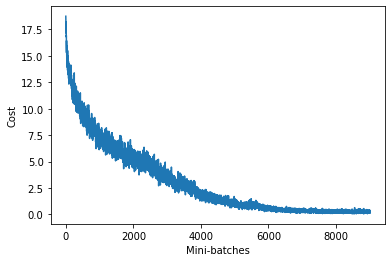

Test accuracy: 0.975420


In [3]:
# WATCHING COST FUNCTION
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
kfold_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform)

mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=92, batch_size=512, verbose=True, 
                  learning_rate=0.1, hidden_layer_width=2000, show_plots=True, lr_decay=True, momentum=0.99)
t = time.time()
mlp.train(kfold_dataset)
elapsed = time.time() - t
print("Elapsed training time: %f" %elapsed)
mlp.test(kfold_dataset, final_test=True)

91.83673469387756

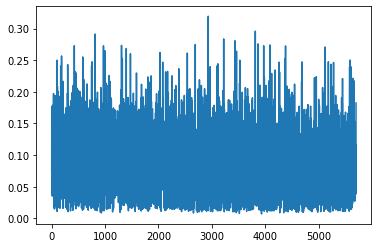

In [26]:
# accuracy = 0
# for i in range(mlp.test_Y.shape[0]):
#   if (mlp.test_Y[i, :] - mlp.test_Y_hat[i, :]).sum() == 0:
#     accuracy += 1
# accuracy /= mlp.test_Y.shape[0]
# print(accuracy)

0.08018


In [5]:
# RUNNING the FINAL TEST

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=False)
# mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=1, batch_size=256, verbose=True, learning_rate=0.01, hidden_layer_width=100)
# mlp.train(train_dataset) # train on entire training dataset
mlp.test(kfold_dataset, final_test=True)

Files already downloaded and verified
Test accuracy: 0.975420


In [14]:
mlp.initialize_weights()
mlp.test(kfold_dataset, final_test=True)
# print(mlp.V)

Test accuracy: 0.096480


In [0]:
# TESTING KFOLD and METRICS

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
kfold_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)

mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=100, batch_size=256, verbose=True, learning_rate=0.01, hidden_layer_width=100)
mlp.cross_validate(kfold_dataset, n_splits=2)

Files already downloaded and verified


ValueError: ignored

In [0]:
for i in range(5):
  plt.imshow(mlp.test_Y[i:10*(i+1),:] - mlp.convert_to_01(mlp.test_Y_hat[i:10*(i+1),:]))

In [0]:
# PLAYING with HYPERPARAMETERS --- nice result here...

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform)

mlp = TwoLayerMLP(hidden_activation='sigmoid', n_epochs=15, batch_size=256, verbose=True, learning_rate=0.005, hidden_layer_width=100)
mlp.train(train_dataset)
plt.plot(mlp.cost)
plt.ylabel('Cost')
plt.xlabel('Mini-batches')
# test_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, train=False, transform=transform)
# mlp.test(test_dataset)

Files already downloaded and verified
Finished training epoch 1.


KeyboardInterrupt: ignored

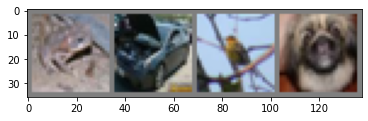

 frog   car  bird   dog


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def image_show(img):
  img = img/2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

# data_iter = iter(train_loader)
images, labels = iter(train_loader).next()

image_show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 